In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Scripts'
os.chdir(path)

from rl_glue_horde import RLGlueHorde
from utils import ReplayBuffer, MazeTileCoder
from toy_horde import Horde
from toy_env_horde import ToyEnvironment
import seaborn as sns
import tiles3 as tc
import scipy.stats as st
import random

path ='/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Notebooks/GVF'
os.chdir(path)

In [51]:
### inherit the abstract class

class Horde(BaseHorde):
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    def horde_init(self, horde_info= {}):
        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(horde_info.get("seed"))
        # behaviour policy 
        self.policy = horde_info.get("policy")
        self.on_policy = horde_info.get("on_policy", False)
        
        if self.on_policy:
            self.epsilon = horde_info.get("epsilon", 0.05)
            self.on_policy_GVF = horde_info.get("on_policy_GVF")
        self.valueGVF_number = horde_info.get("valueGVF_number")
        self.actionGVF_number = horde_info.get("actionGVF_number")
        dic = {}
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            if(horde_info.get(name) != None):
                dic[name] = ValueGVF(horde_info.get(name))
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            if(horde_info.get(name) != None):
                dic[name] = ActionValueGVF(horde_info.get(name))
        self.GVFs = dic
        """Setup for the agent called when the experiment first starts."""

    def horde_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's env_start function.
        Returns:
            The first action the agent takes. 
        """
        
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        if self.on_policy:
            ## epsilon greedy policy
            u = np.random.uniform(0,1)
            if u < self.epsilon:
                pass
            else:
                pi = self.GVFs[self.on_policy_GVF].policy
                action = self.rand_generator.choice(range(self.policy.shape[1]), p=pi[state])
        
        # value gvf
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                gvf.start(state, action)
                self.GVFs.update({name : gvf})
            
        # action value gvf
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                gvf.start(state, action)
                self.GVFs.update({name : gvf})
            
        self.last_state = state
        self.last_action = action
        
        return action

    def horde_step(self, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # value gvf
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        if self.on_policy:
            ## epsilon greedy policy
            u = np.random.uniform(0,1)
            if u < self.epsilon:
                action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
            else:
                pi = self.GVFs[self.on_policy_GVF].policy
                action = self.rand_generator.choice(range(self.policy.shape[1]), p=pi[state])
        
        
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.step(state, rho)
                self.GVFs.update({name : gvf})
            
        # action value gvf    
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.step(state, action, rho)
                self.GVFs.update({name : gvf})
        
        self.last_state = state
        self.last_action = action
        
        return self.last_action

    def horde_end(self, state):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """
        action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        
        if self.on_policy:
            ## epsilon greedy policy
            u = np.random.uniform(0,1)
            if u < self.epsilon:
                action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
            else:
                pi = self.GVFs[self.on_policy_GVF].policy
                action = self.rand_generator.choice(range(self.policy.shape[1]), p=pi[state])
        
        # value gvf
        for j in range(1, self.valueGVF_number + 1):
            name = "V{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.end(state, rho)
                self.GVFs.update({name : gvf})
            
        # action value gvf    
        for j in range(1, self.actionGVF_number + 1):
            name = "A{}".format(j)
            gvf = self.GVFs.get(name)
            if gvf != None:
                rho = gvf.policy[self.last_state, self.last_action] / self.policy[self.last_state, self.last_action]
                gvf.end(state, action, rho)
                self.GVFs.update({name : gvf})
            
    def horde_cleanup(self):
        """Cleanup done after the agent ends."""

    def horde_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

In [11]:
class ValueGVF:
    def __init__(self, agent_info={}):
        self.lambd = agent_info.get("lambda", 0.1)
        self.alpha = agent_info.get("alpha", 0.1)
        self.beta =  0.1*self.alpha
        self.gamma = agent_info.get("gamma", 0.95)
        self.last_gamma = self.gamma
        self.current_gamma = None
        self.last_state = None
        
        self.num_tilings = agent_info.get("num_tilings", 4)
        self.num_tiles = agent_info.get("num_tiles", 4)
        self.tc = MazeTileCoder(num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)
        self.iht_size = self.tc.iht_size
        self.weights = np.zeros(self.iht_size)
        self.hWeights = np.zeros(self.iht_size)
        self.eligTrace = np.zeros(self.iht_size)

        self.objective_states = agent_info.get("objective_states", [[2,4]])
        if len(self.objective_states) == 1:
            self.objective_states = self.objective_states[0]
            
        self.transition_gen_ = agent_info.get("transition_gen")
        self.transition_gen_params = agent_info.get("transition_gen_params", {})
        
        self.policy = agent_info.get("policy")
        self.values = np.zeros((6,10))
        obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
        for (i,j) in obstacles:
            self.values[i,j] = np.nan
        
    def transition_gen(self, state):
        return self.transition_gen_(self.objective_states, state, self.gamma, self.transition_gen_params)
    
    def argmax(self, state):
        top = float("-inf")
        ties = []

        for i in range(self.num_actions):
            if q_values[i] > top:
                top = self.q_values[state][i]
                ties = []

            if q_values[state][i] == top:
                ties.append(i)
        return ties
    
    def start(self, state, action, rho = 1.0):
        self.last_state = state
        self.last_action = action
        self.eligTrace = np.zeros(self.iht_size)
        
        return action
    
    def step(self, state, rho = 1.0): 
        # get relevant feature
        last_i, last_j = self.tc.get_observation(self.last_state)
        last_state_vector = self.tc.get_state_vector(self.last_state)
        current_state_vector = self.tc.get_state_vector(state)
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        ## retrieve the values
        self.last_state_value = np.sum(self.weights*last_state_vector)
        self.current_state_value = np.sum(self.weights*current_state_vector)
        
        ##GTD lambda updates
        self.delta = self.cumulant + (gamma * self.current_state_value - self.last_state_value)
        self.eligTrace = rho*(self.lambd * self.last_gamma * self.eligTrace + last_state_vector)
        self.weights += self.alpha *(self.delta * self.eligTrace - gamma*(1-self.lambd)*np.dot(self.eligTrace, self.hWeights)*current_state_vector)
        self.hWeights += self.beta * (self.delta*self.eligTrace - np.sum(self.hWeights*last_state_vector)*last_state_vector)
        
        self.values[last_i, last_j] = np.sum(self.weights*last_state_vector)
        
        self.last_gamma = gamma
        self.prediction = self.last_state_value
        
        self.last_state = state
        
    def end(self, state, rho = 1.0): 
        # get relevant feature
        last_i, last_j = self.tc.get_observation(self.last_state)
        last_state_vector = self.tc.get_state_vector(self.last_state)
        current_state_vector = self.tc.get_state_vector(state)
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        ## retrieve the values
        self.last_state_value = np.sum(self.weights*last_state_vector)
        self.current_state_value = np.sum(self.weights*current_state_vector)
        
        ##GTD lambda updates
        self.delta = self.cumulant + (gamma * self.current_state_value - self.last_state_value)
        self.eligTrace = rho*(self.lambd * self.last_gamma * self.eligTrace + last_state_vector)
        self.weights += self.alpha *(self.delta * self.eligTrace - gamma*(1-self.lambd)*np.dot(self.eligTrace, self.hWeights)*current_state_vector)
        self.hWeights += self.beta * (self.delta*self.eligTrace - np.sum(self.hWeights*last_state_vector)*last_state_vector)
        
        self.values[last_i, last_j] = np.sum(self.weights*last_state_vector)
        
        self.last_gamma = gamma
        self.prediction = self.last_state_value
        
        
        self.last_gamma = gamma
        self.prediction = self.last_state_value    

In [4]:
def run_experiment(horde_info, env_info = {},
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = Horde
    rl_glue = RLGlueHorde(env, horde)

    rl_glue.rl_init(horde_info, env_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode%plot_freq == 0:
            print(episode)
    
    return rl_glue

In [23]:
def deterministic_cumulant(objective_state, state, gamma, params):
    r = params.get("r", 10)
    if state == objective_state:
        cumulant = r
        gamma = 0
    else:
        cumulant = 0
        gamma = gamma
    return cumulant, gamma

In [24]:
def bernouilli_cumulant(objective_state, state, gamma, params):
    r = params.get("r", 10)
    if state == objective_state:
        cumulant = np.random.binomial(1, 0.5)*2*r
        gamma = 0
    else:
        cumulant = 0
        gamma = gamma
    return cumulant, gamma

In [12]:
def banana_or_apple(objective_states, state, gamma):
    state = [state //10, state%10]
    r = params.get("r", 10)
    if state == objective_states[0]:
        cumulant = r
        gamma = 0
    elif state == objective_states[1]:
        cumulant = np.random.binomial(1, 0.5)*2*r
        gamma = 0
    else: 
        cumulant = 0
        gamma = gamma
    return cumulant, gamma 

In [8]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
random.seed(50)
policy_2 = st.dirichlet.rvs(alpha = [2,4,3,1], size = 6*10)
policy_3 = np.zeros((6*10, 4))
policy_3[:,1] = 1

V_info_1 = {
    "policy": policy_2,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "num_tilings" : 4,
    "num_tiles" : 4,
    "objective_state" : [2,4],
    "transition_gen" : deterministic_cumulant}

V_info_2 = {
    "policy": policy_2,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "num_tilings" : 4,
    "num_tiles" : 4,
    "transition_gen" : bernouilli_cumulant,
    "objective_state" : [4,6]}

V_info_3 = {
    "control" : True,
    "policy": policy,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "transition_gen" : banana_or_apple,
    "objective_states" : [[2,4], [4,8]]}

horde_info = {
    "valueGVF_number" : 3,
    "actionGVF_number" : 0,
    "V1" : V_info_1,
    "V2" : V_info_2,
    "V3" : V_info_3,
    "policy" : policy,
    "on_policy" : False
}
env_info = {
    "end_states" : [[0,8]]
}

In [9]:
rl = run_experiment(horde_info, env_info, 100)

NameError: name 'ValueGVF' is not defined

In [20]:
v = rl.horde.GVFs["V3"].values

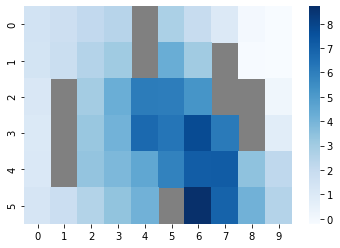

In [21]:
h = sns.heatmap(v, cmap = "Blues")
h.set_facecolor('grey')
plt.show()

In [65]:
class ActionValueGVF:
    def __init__(self, agent_info={}):
        
        ## parameters
        self.lambd = agent_info.get("lambda", 0.1)
        self.alpha = agent_info.get("alpha", 0.1)
        self.beta = agent_info.get("beta", 0.01)
        self.gamma = agent_info.get("gamma", 0.95)
        self.num_actions = agent_info.get("num_actions", 4)
        self.last_gamma = self.gamma
        self.current_gamma = None
        self.last_state = None
        
        ## tile coding
        self.num_tilings = agent_info.get("num_tilings", 4)
        self.num_tiles = agent_info.get("num_tiles", 4)
        
        self.iht_size = agent_info.get("iht_size", 4096)
        self.weights = np.zeros(self.iht_size*self.num_actions)
        self.hWeights = np.zeros(self.iht_size*self.num_actions)
        self.eligTrace = np.zeros(self.iht_size*self.num_actions)

        self.tc = MazeTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)
        ## all_state_action_vectors
        
        self.all_state_action_vectors = np.zeros((60, self.num_actions, self.iht_size*self.num_actions))
        for s in range(60):
            for a in range(self.num_actions):
                self.all_state_action_vectors[s, a, :] = self.get_state_action_vector(s,a)
                
        ## objective state
        self.objective_states = agent_info.get("objective_states", [2,4])
        if len(self.objective_states) == 1:
            self.objective_states = self.objective_states[0]
        self.transition_gen_ = agent_info.get("transition_gen")
        
        ## distrib params
        self.mu = agent_info.get("mu", 10)
        self.sigma = agent_info.get("sigma", 0.001)
        
        self.control = agent_info.get("control", False)
        if not self.control:
            self.policy = agent_info.get("policy")
        else:
            self.policy = np.ones((60, self.num_actions))/self.num_actions
        self.q_values = np.zeros((60, self.num_actions))
        self.obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
        
    def get_state_action_vector(self, state, a):
        state_vector = self.tc.get_state_vector(state)
        state_action_vector = np.zeros(self.iht_size*self.num_actions)
        state_action_vector[a*self.iht_size:(a+1)*self.iht_size] = state_vector
        return state_action_vector
        
    def transition_gen(self, state):
        return self.transition_gen_(self.objective_states, state, self.gamma)
    
    def argmax(self, state):
        top = float("-inf")
        ties = []
        q = self.q_values[state]
        for i in range(self.num_actions):
            if q[i] > top:
                top = q[i]
                ties = []

            if q[i] == top:
                ties.append(i)
        return ties
        
    def update_qvalues(self):
        self.q_values = np.sum(self.all_state_action_vectors * self.weights, -1)
        if self.control:
            for s in range(60):
                self.update_greedy_policy(s)
        
    def update_greedy_policy(self, state):
        arg_max = self.argmax(state)
        for action in range(4):
            if (action in arg_max):
                self.policy[state, action] = 1/len(arg_max)
            else :
                self.policy[state, action] = 0
    
    def start(self, state, action, rho = 1.0):
        self.last_state = state
        self.last_action = action
        self.eligTrace = np.zeros(self.iht_size*self.num_actions)
        return action

    
    def step(self, state, action, rho = 1.0): 
        # get relevant feature
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        ## retrieve the values
        last_vector = self.get_state_action_vector(self.last_state, self.last_action)
        self.last_value = np.sum(self.weights*last_vector)
        current_vector = np.zeros(self.iht_size*self.num_actions)
        
        ## mean current vector
        for a in range(4):
            current_vector += self.policy[state][a]*self.get_state_action_vector(state, a) 
        current_value = np.sum(self.weights*current_vector)
        
        ##GQ lambda update
        self.delta = self.cumulant + (gamma * current_value - self.last_value)
        self.eligTrace = rho * self.lambd * self.last_gamma * self.eligTrace + last_vector
        self.weights += self.alpha *(self.delta * self.eligTrace - gamma*(1-self.lambd)*np.sum(self.eligTrace * self.hWeights)*current_vector)
        self.hWeights += self.beta * (self.delta*self.eligTrace - np.sum(self.hWeights*last_vector)*last_vector)
        
        ## update q_values
        #self.q_values[self.last_state, self.last_action] = np.sum(self.weights*last_vector)
        
        self.update_qvalues()

        
        #for s in range(60):
        #    for a in range(self.num_actions):
        #        vector = self.get_state_action_vector(s, a)
        #        self.q_values[s, a] = np.sum(self.weights*vector)
        #        if self.control:
        #            self.update_greedy_policy(s)
        
        self.last_gamma = gamma
        self.last_state = state
        self.last_action = action
        
    def end(self, state, action, rho = 1.0): 
        # get relevant feature
        
        cumulant, gamma = self.transition_gen(state)
        self.cumulant = cumulant
        
        ## retrieve the values
        last_vector = self.get_state_action_vector(self.last_state, self.last_action)
        self.last_value = np.sum(self.weights*last_vector)
        current_vector = np.zeros(self.iht_size*self.num_actions)
        
        ## mean current vector
        for a in range(4):
            current_vector += self.policy[state][a]*self.get_state_action_vector(state, a) 
        current_value = np.sum(self.weights*current_vector)
        
        ##GQ lambda update
        
        self.delta = self.cumulant + (gamma * current_value - self.last_value)
        self.eligTrace = rho * self.lambd * self.last_gamma * self.eligTrace + last_vector
        self.weights += self.alpha *(self.delta * self.eligTrace - gamma*(1-self.lambd)*np.sum(self.eligTrace * self.hWeights)*current_vector)
        self.hWeights += self.beta * (self.delta*self.eligTrace - np.sum(self.hWeights*last_vector)*last_vector)
        
        ## update q_values
        
        #self.q_values[self.last_state, self.last_action] = np.sum(self.weights*last_vector)
        self.update_qvalues()
            
        #for s in range(60):
        #    for a in range(self.num_actions):
        #        vector = self.get_state_action_vector(s, a)
        #        self.q_values[s, a] = np.sum(self.weights*vector)
        #        if self.control:
        #            self.update_greedy_policy(s)
        
        self.last_gamma = gamma
        self.last_state = state
        #self.last_state = state
        #self.last_action = action 

In [66]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
random.seed(50)
policy_2 = st.dirichlet.rvs(alpha = [1,7,1,1], size = 6*10)

A_info_1 = {
    "control": False,
    "policy": policy_3,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "objective_states" : [[2,4]],
    "transition_gen" : deterministic_cumulant,
    "num_tiles" : 4,
    "num_tilings" : 4}

A_info_2 = {
    "control" : False,
    "policy": policy_2,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "transition_gen" : bernouilli_cumulant,
    "objective_states" : [[4,6]]}

A_info_3 = {
    "control" : True,
    "policy": policy,
    "lambda" : 0.1,
    "alpha": 0.1/4,
    "transition_gen" : banana_or_cherry,
    "objective_states" : [[2,4], [4,6]]}

horde_info = {
    "valueGVF_number" : 0,
    "actionGVF_number" : 3,
    "A1" : A_info_1,
    "A2" : A_info_2,
    "A3" : A_info_3,
    "policy" : policy,
    "on_policy" : True,
    "epsilon" : 0.05,
    "on_policy_GVF" : "A3"
    }
env_info = {
    "end_states" : [[2,4], [4,6]]
}

In [70]:
rl = run_experiment(horde_info, env_info, 10)

10


In [72]:
tt = rl.horde.GVFs["A3"].q_values

In [75]:
tt.argmax(-1).reshape(6,10)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 2, 2, 0, 0],
       [0, 1, 1, 1, 1, 1, 2, 2, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 2, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]])

In [37]:
seed = 22
horde_info["seed"] = seed
rl = run_experiment(horde_info, env_info, 500)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [31]:
q = rl.horde.GVFs["A3"].q_values

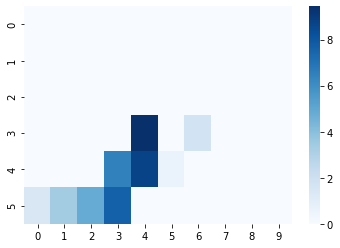

In [32]:
q0 = q[:, 0]
q1 = q[:, 1]
q2 = q[:, 2]
q3 = q[:, 3]

h0 = sns.heatmap(q0.reshape(6,10), cmap = "Blues")

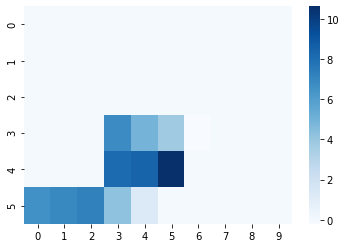

In [33]:
h1 = sns.heatmap(q1.reshape(6,10), cmap = "Blues")

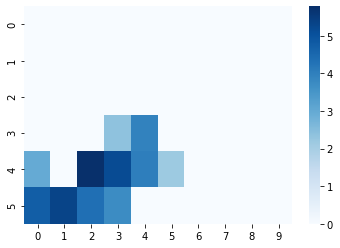

In [34]:
h2 = sns.heatmap(q2.reshape(6,10), cmap = "Blues")

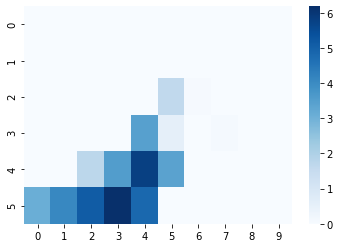

In [35]:
h3 = sns.heatmap(q3.reshape(6,10), cmap = "Blues")

In [170]:
q.argmax(-1).reshape(6,10)

array([[1, 1, 2, 2, 0, 2, 2, 3, 0, 2],
       [1, 1, 2, 2, 0, 2, 2, 0, 1, 2],
       [0, 0, 1, 1, 0, 3, 3, 0, 0, 2],
       [2, 0, 1, 0, 0, 0, 1, 2, 0, 2],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 3],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 3]])

## count the visited states

In [78]:
num_runs = 10
num_episodes = 100
all_state_visits = []
for run in tqdm(range(num_runs)):
    print("run")
    print(run)
    env = ToyEnvironment
    horde = Horde
    horde_info["seed"] = run
    rl_glue = RLGlueHorde(env, horde)
    rl_glue.rl_init(horde_info, env_info)
    state_visits = np.zeros(60)
    for episode in range(num_episodes):
        # Runs an episode while keeping track of visited states
        state, action = rl_glue.rl_start()
        if episode >= num_episodes - 10:
            state_visits[state] += 1
        is_terminal = False
        while not is_terminal:
            state, action, is_terminal = rl_glue.rl_step()
            if episode >= num_episodes - 10:
                state_visits[state] += 1
    all_state_visits.append(state_visits)








  0%|          | 0/10 [00:00<?, ?it/s]

run
0








 10%|█         | 1/10 [00:49<07:25, 49.52s/it]

run
1








 20%|██        | 2/10 [01:27<06:09, 46.20s/it]

run
2








 30%|███       | 3/10 [02:48<06:34, 56.42s/it]

run
3








 40%|████      | 4/10 [03:49<05:47, 57.97s/it]

run
4








 50%|█████     | 5/10 [05:02<05:11, 62.34s/it]

run
5








 60%|██████    | 6/10 [06:07<04:12, 63.19s/it]

run
6








 70%|███████   | 7/10 [06:55<02:56, 58.77s/it]

run
7








 80%|████████  | 8/10 [07:54<01:57, 58.67s/it]

run
8








 90%|█████████ | 9/10 [08:43<00:55, 55.94s/it]

run
9








100%|██████████| 10/10 [10:00<00:00, 60.01s/it]


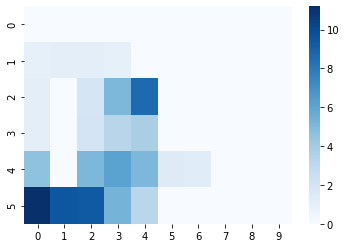

In [287]:
sns.heatmap(np.round(np.array(all_state_visits).mean(0).reshape(6,10), 2), cmap = "Blues")

In [289]:
mean_state_visits = np.round(np.array(all_state_visits).mean(0).reshape(6,10), 2)

In [291]:
np.save("mean_state_visits_10runs", mean_state_visits)

In [79]:
mean_state_visits = np.round(np.array(all_state_visits).mean(0).reshape(6,10), 2)

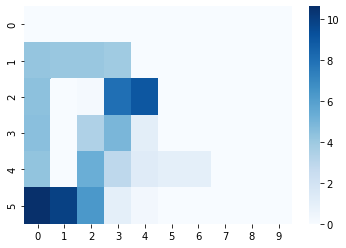

In [81]:
 sns.heatmap(mean_state_visits, cmap = "Blues")